
 Exercise 1 of the calcium imaging module can be found at the bottom of this notebook

In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import psutil
from pathlib import Path
import os

# CaImAn funtions and objects
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF

import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import auxiliary_functions as aux


import seaborn as sns
sns.set_theme(context='notebook',style='white',font_scale=1.5)

In [2]:
# download data for the lesson (this can take a few minutes)
download_data('https://surfdrive.surf.nl/files/index.php/s/HeYXPdvMO87fbq7')

In [3]:
# set path to video of the full field of view
input_tif_file_path_FOV = 'data/calcium_video.tif'   
input_tif_file_path = 'data/caiman_video_trial_0.tif'  

In [4]:
FOV = cm.load(input_tif_file_path_FOV) # load video with complete field of view (FOV)

In [5]:
# play video (a new window will open)
FOV.play(gain = 1,  #light intensity of video
         magnification = 1, #size of display movie
         fr = 20) # frame rate at which the movie is played

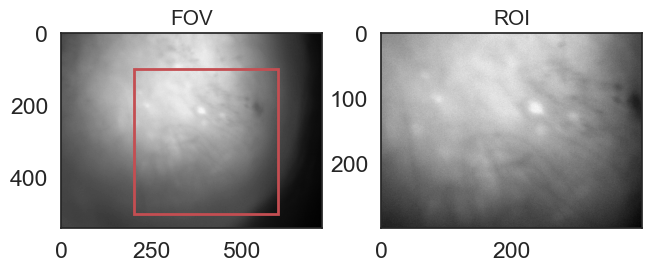

In [6]:
# Let's visualize the FOV and the ROI
aux.plot_FOV(FOV_file = input_tif_file_path_FOV , ROI_file = input_tif_file_path)

In [7]:
# load movie and compute mean imges with caiman functions
original_movie = cm.load(input_tif_file_path)
mean_image = cm.summary_images.mean_image(input_tif_file_path)
correlation_image,pnr_image = cm.summary_images.correlation_pnr(original_movie,swap_dim=False)

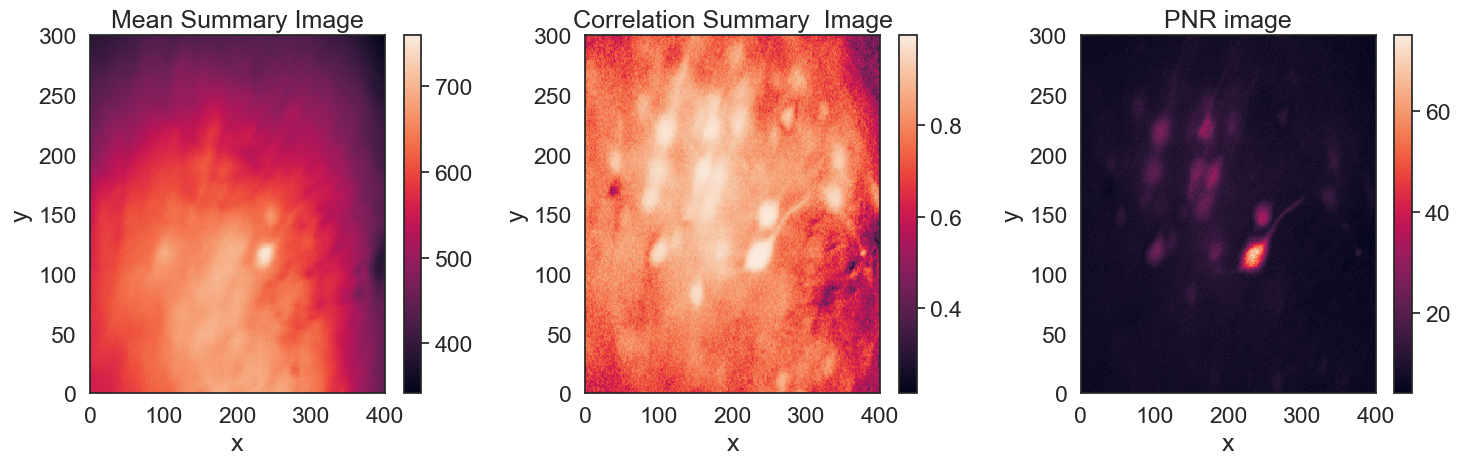

In [8]:
# Plot summary images
figure, axes = plt.subplots(1,3,figsize=(15,5))


axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Mean Summary Image')

axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Correlation Summary  Image')

axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title('PNR image')

mesh0 = axes[0].pcolormesh(mean_image)
mesh1 = axes[1].pcolormesh(correlation_image)
mesh2 = axes[2].pcolormesh(pnr_image)

figure.colorbar(mesh0,ax=axes[0])
figure.colorbar(mesh1,ax=axes[1])
figure.colorbar(mesh2,ax=axes[2])


plt.tight_layout()

In [9]:
# Define parameters for motion correction in a dictionary

parameters_motion_correction = { 'pw_rigid': True,       # flag for performing piecewise-rigid motion correction (otherwise just rigid)
                                'gSig_filt': (5, 5),     # size of high pass spatial filtering, used in 1p data
                                'max_shifts': (25, 25),  # maximum allowed rigid shift in pixels (view the movie to get a sense of motion)
                                'niter_rig': 1 ,
                                'strides': (48, 48),     # create a new patch every x pixels for pw-rigid correction
                                'overlaps': (96, 96),    # overlap between pathes (size of patch strides+overlaps)
                                'upsample_factor_grid': 1,
                                'num_frames_split': 80,  # length in frames of each chunk of the movie (to be processed in parallel)
                                'max_deviation_rigid': 15, # maximum deviation allowed for patch with respect to rigid shifts
                                'shifts_opencv': True, 
                                'use_cuda': False, 
                                'nonneg_movie': True,
                                'border_nan': 'copy'}




# We compute and store the minimum value of the movie, that the algorithm needs to make values all positive
original_movie = cm.load(input_tif_file_path)
parameters_motion_correction['min_mov'] = np.min(original_movie) 

# pass parameters to caiman object
opts = params.CNMFParams(params_dict = parameters_motion_correction)

In [10]:
n_processes = psutil.cpu_count() # counts local cpus
cm.cluster.stop_server() #stop any already running clusters
# Start a new cluster
c, dview, n_processes = cm.cluster.setup_cluster(backend='local',
                                                 n_processes=n_processes,
                                                 single_thread=False)

In [11]:
#make directory to save motion corrected videos
Path("data/motion_corrected").mkdir(parents=True, exist_ok=True)

#create an object for motion correction
mc = MotionCorrect(input_tif_file_path, dview = dview, **opts.get_group('motion'))
# Perform rigid motion correction
mc.motion_correct_rigid(save_movie = True, template = None)

#perform non-rigid motion correction
total_template_rig = mc.total_template_rig
mc.motion_correct_pwrigid(save_movie=True, template = total_template_rig)
fname_tot_els = mc.fname_tot_els[0]

#reshape memmap files for source extraction
m_els = cm.load(fname_tot_els)
fname_tot_els  = m_els.save('motion_corrected_video.mmap',  order='C')
Path(fname_tot_els).rename(f"data/motion_corrected/{fname_tot_els}")

FileExistsError: [WinError 183] Kan geen bestand maken dat al bestaat: 'motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500.mmap' -> 'data/motion_corrected/motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500.mmap'

In [12]:
# play original video, rigid motion corrected and pw motion corrected
# concatenate the three movies along axes 2
m_rig = cm.load(mc.fname_tot_rig)
m_els = cm.load(mc.fname_tot_els)

gain = 1
magnification = 1
fr = 10

movies_chained = cm.concatenate([original_movie,m_rig,m_els],axis = 2).resize(1,1,.5).play(gain = gain, magnification = magnification, fr = fr)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.35it/s]


In [13]:
final_size = mc.total_template_els.shape
winsize = 100
swap_dim = False
resize_fact_flow = .1    # downsample for computing ROF

tmpl_orig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    input_tif_file_path, final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_els[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

In [14]:
#crispness calculation
print('Crispness original: '+ str(int(crispness_orig)))
print('Crispness rigid: '+ str(int(crispness_rig)))
print('Crispness elastic: '+ str(int(crispness_els)))

Crispness original: 1059
Crispness rigid: 858
Crispness elastic: 882


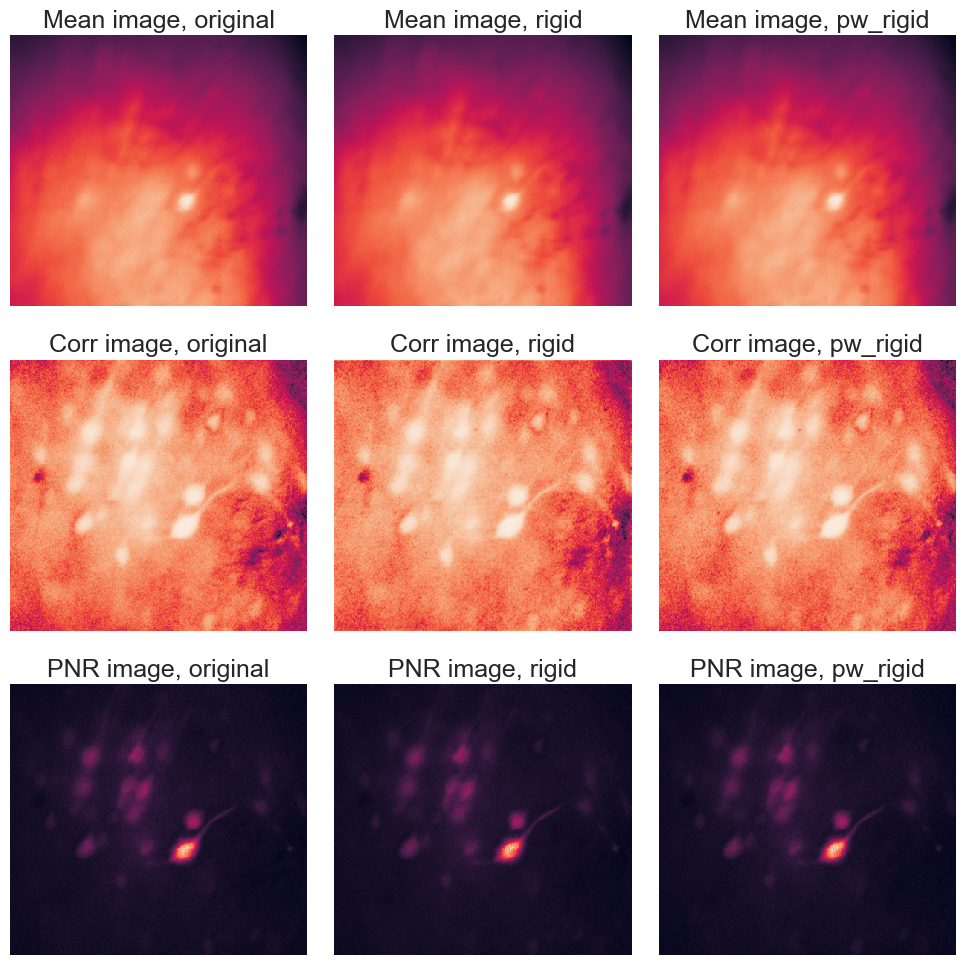

In [15]:
figure,axes  = plt.subplots(3,3,figsize=(10,10))
movies = {'original':input_tif_file_path,
          'rigid':mc.fname_tot_rig[0],
          'pw_rigid':mc.fname_tot_els[0]}

for col,movie in enumerate(movies.keys()):

    movie_array = cm.load(movies[movie])
    mean_image = cm.summary_images.mean_image(movies[movie])
    correlation_image,pnr_image = cm.summary_images.correlation_pnr(movie_array,swap_dim=False)

    axes[0,col].set_title(f'Mean image, {movie}')
    axes[0,col].pcolormesh(mean_image)
    axes[0,col].axis('off')


    axes[1,col].set_title(f'Corr image, {movie}')
    axes[1,col].pcolormesh(correlation_image)
    axes[1,col].axis('off')


    axes[2,col].set_title(f'PNR image, {movie}')
    axes[2,col].pcolormesh(pnr_image)
    axes[2,col].axis('off')

plt.tight_layout()

In [18]:
# load motion corrected video
input_mmap_file_path = 'data/motion_corrected/motion_corrected_video_d1_300_d2_400_d3_1_order_C_frames_500.mmap'
Yr, dims, T = cm.load_memmap(input_mmap_file_path)         # load mmap file
images = Yr.T.reshape((T,) + dims, order='F' )

In [21]:
gSig = 9
corr_image, pnr_image = cm.summary_images.correlation_pnr(images[::1], gSig=gSig, swap_dim=False)



Text(0.5, 1.0, 'PNR image')

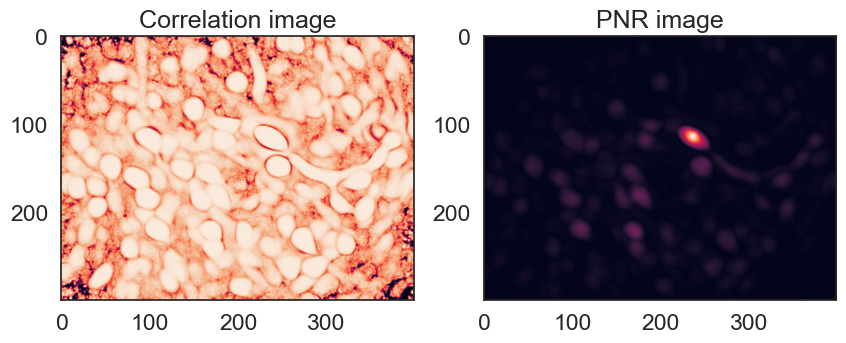

In [22]:
figure, axes = plt.subplots(1, 2,figsize=(10,5))
axes[0].imshow(corr_image)
axes[0].set_title('Correlation image')
axes[1].imshow(pnr_image)
axes[1].set_title('PNR image')
    

In [23]:
# create dictionary with source extraction parameters

parameters_source_extraction ={ 'fr': 10,               # movie frame rate
                               'decay_time': 0.1,       # length of a typical transient in seconds
                               'min_corr': 0.7,   # min peak value from correlation image
                               'min_pnr': 7,     # min peak to noise ration from PNR image
                                'p': 1,                # order of the autoregressive system 
                               'K': None,              # upper bound on number of components per patch, in general None
                               'gSig': (4, 4),         # gaussian width of a 2D gaussian kernel, which approximates a neuron
                               'gSiz': (17, 17),       # average diameter of a neuron, in general 4*gSig+1
                               'ring_size_factor': 1.4, # radius of ring is gSiz*ring_size_factor
                               'merge_thr': 0.7, 'rf': 60,
                               'stride': 30, 'tsub': 1, 'ssub': 2, 'p_tsub': 1, 'p_ssub': 2, 'low_rank_background': None,
                               'nb': 0, 'nb_patch': 0, 'ssub_B': 2, 'init_iter': 2,
                               'method_init': 'corr_pnr', 'method_deconvolution': 'oasis',
                               'update_background_components': True,
                               'center_psf': True, 'border_pix': 0, 'normalize_init': False,
                               'del_duplicates': True, 'only_init': True}
# create caiman parameters objects
opts = params.CNMFParams(params_dict=parameters_source_extraction)

In [24]:
cnmf_object = cnmf.CNMF(n_processes=n_processes, dview=dview, params=opts)
cnmf_object.fit(images)

In [25]:
# Save the cnmf object as a hdf5 file
Path("data/source_extracted").mkdir(parents=True, exist_ok=True)
output_cnmf_file_path = 'data/source_extracted/calcium_video_0_cnmf.hdf5'
cnmf_object.save(output_cnmf_file_path)

In [26]:
cnmf_object.estimates.C.shape

(24, 500)

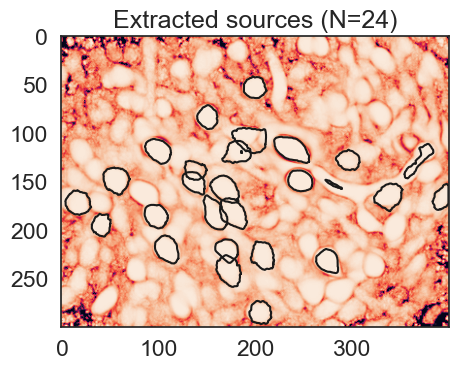

In [27]:
# display footprints in the ROI
figure, axes = plt.subplots(1,figsize=(5,5))
plt.title(f'Extracted sources (N={cnmf_object.estimates.A.shape[1]})')
pos = axes.imshow(corr_image)
coordinates = cm.utils.visualization.get_contours(cnmf_object.estimates.A, np.shape(corr_image), 0.2, 'max')
for c in coordinates:
    v = c['coordinates']
    c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                    np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
    axes.plot(*v.T, c='k')

Exercise 1

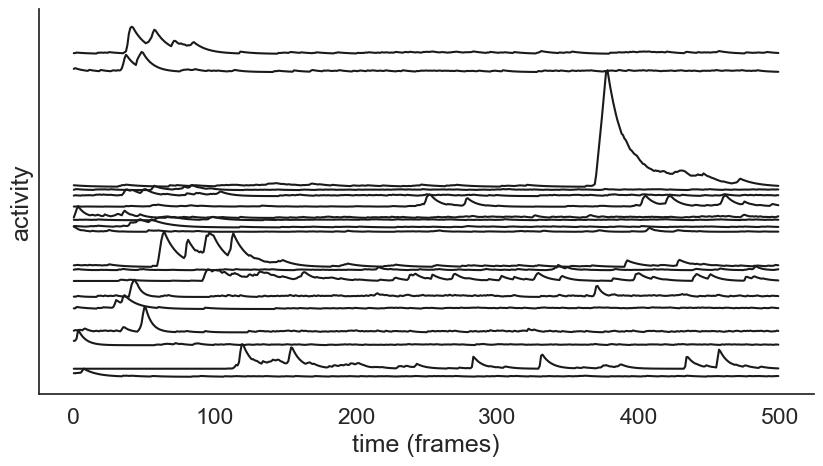

In [40]:
import random

# Number of objects (sources) in C_0
num_objects = len(C_0)

# Randomly choose a subset size between 1 and the total number of objects
subset_size = random.randint(1, num_objects)

# Randomly select a subset of indices
selected_indices = np.sort(random.sample(range(num_objects), subset_size))

# Plot temporal traces
figure, axes = plt.subplots(1, figsize=(10, 5))
C_0 = cnmf_object.estimates.C.copy()

# Adjust the first trace (if it exists in the selected indices)
if 1 in selected_indices:
    C_0[1] += C_0[0].min()

# Adjust and plot only the selected traces
for i in selected_indices[1:]:
    C_0[i] += C_0[i].min() + C_0[:i].max()
    axes.plot(C_0[i], c='k')

# Label the axes and clean up the plot
axes.set_xlabel('time (frames)')
axes.set_yticks([])  # Remove y-axis ticks
sns.despine()  # Remove top and right spines
axes.set_ylabel('activity')
plt.show()



Text(0.5, 1.0, 'Histogram of Pixel Values for Selected Pixels')

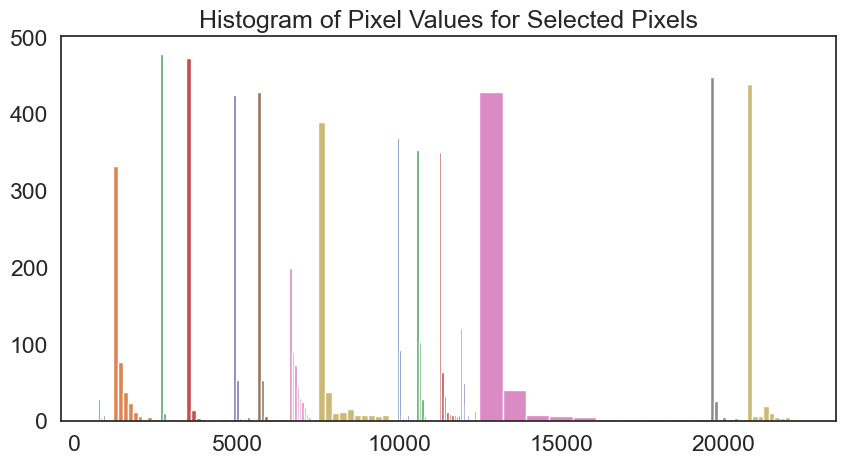

In [42]:
plt.figure(figsize=(10, 5))
for i in selected_indices[1:]:
        C_0[1] += C_0[0].min()

for i in selected_indices[1:]:
       plt.hist(C_0[i])
plt.title("Histogram of Pixel Values for Selected Pixels")


neuron pixels show a wider distribution of pixel values resulting from the fluctuation over time, which correspond to calcium transients. In contrast, background pixels show lower variability and the peak values are lower.

The reason we need source extraction is to reduce noise and and overlapping signals. this results in a clearer and more accurate representation of neuronal activity.